In [1]:
from example.discretizer.utils import IsTrafficLightNearby, StopAreaNearby, FrontObjects, IdleTime, IsTwoWheelNearby, Rotation, Velocity, IsZebraNearby, LanePosition, PedestrianNearby, BlockProgress,NextIntersection
from pgeon.intention_introspector import IntentionIntrospector
from pgeon.desire import Desire
from example.discretizer.discretizer_d0 import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
from example.discretizer.discretizer_d2 import AVDiscretizerD2

import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Dict, Tuple
import networkx as nx

## Common initialization (valid for each discretiser)

In [2]:
environment = SelfDrivingEnvironment(city='all')
discretizer_configs = {
    'a': {'obj_discretizer': 'binary', 'vel_discretizer': 'binary' },
    'b': {'obj_discretizer': 'multiple', 'vel_discretizer': 'binary'}
    }

default_config = {'obj_discretizer': 'binary', 'vel_discretizer': 'binary'}
commitment_threshold = 0.5

In [3]:
def roc_curve(discretisers_info: Dict[str, Tuple[PG.PolicyGraph, Set[Desire]]]):
    
    plt.figure(figsize=(10, 6))

    thresholds = np.arange(0, 1, 0.1)

    for discretizer_id, (pg, desires) in discretisers_info.items():
        intention_probabilities = []
        expected_probabilities = []

        for threshold in thresholds:
            ii = IntentionIntrospector(desires, pg)

            intention_prob, expected_prob=ii.get_intention_metrics(commitment_threshold=threshold,desire=any)
            intention_probabilities.append(intention_prob)
            expected_probabilities.append(expected_prob)

        plt.plot(intention_probabilities, expected_probabilities, label=f'Discretizer D{discretizer_id}')           

    plt.xlabel('Intention Probability for any desire')
    plt.ylabel('Expected Intention Probability')
    plt.title('Intention Probability vs Expected Intention Probability for any desire')
    plt.legend()
    plt.grid(True)
    plt.show()
    #plt.savefig(f'roc.png', dpi=100)

In [4]:
def show_metrics(metrics_data, discretizer_id, type='Desire'):
    
    """
    Function to show bar plots with metrics for each desire. The metrics can be 
    desire or intention metrics, based on the value of the parameter 'type' (Desire or Intention).
    """
    desires = list(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(70, 15))

    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        if desire == 'any':
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        else:
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.3

    rects1 = ax.bar(x - width/2, val1, width, label=f'{type} Probability')
    metric_label = 'Expected Action Probability' if type == 'Desire' else 'Expected Intention Probability'
    rects2 = ax.bar(x + width/2, val2, width, label=metric_label)

    ax.set_xlabel(f'Desires', fontsize=45)
    ax.set_ylabel(f'{type}s Metrics', fontsize=45)
    ax.set_title(f'Discretizer D{discretizer_id}', fontsize=50)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=40,rotation = 30)
    
    plt.yticks(fontsize=30)

        
    ax.legend( fontsize=35, loc='upper right' )
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    plt.show()  
    #plt.savefig(f'{type}_{discretizer_id}.png', bbox_inches = 'tight')

In [5]:
def show_all_metrics_per_desire(desires_data, desire, type='Desire'):

    num_discretizers = len(desires_data)
    
    # Calculate grid size for subplots
    cols = 2  # Number of columns in the grid
    rows = (num_discretizers + 1) // cols  # Calculate rows based on number of discretizers

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, (discretizer_id, metrics_data) in enumerate(desires_data.items()):
        ax = axes[i]

        if desire not in metrics_data:
            raise ValueError(f"Desire '{desire}' not found in metrics_data for discretizer '{discretizer_id}'.")

        val1 = metrics_data[desire][0]
        val2 = metrics_data[desire][1]
        
        labels = [desire]
        x = np.arange(len(labels))
        width = 0.10

        rects1 = ax.bar(x - width, val1, width, label=f'{type} Probability')
        metric_label = 'Expected Action Probability' if type == 'Desire' else 'Expected Intention Probability'
        rects2 = ax.bar(x + width, val2, width, label=metric_label)

        #ax.set_xlabel('Desire', fontsize=10)
        ax.set_ylabel(f'{type} Metrics', fontsize=10)
        ax.set_title(f'Discretizer D{discretizer_id}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0)

        ax.legend(loc='upper left')
        
        for rect in rects1:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        for rect in rects2:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Hide any unused subplots if the grid is larger than the number of discretizers
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    #plt.savefig('ciao.png', dpi=200)

#show_all_metrics_per_desire(intentions_data, "any", type='Intention')


'ANY' desire

In [6]:
any = Desire("any", None, set())


Desires Iteration 1

In [7]:
stop_traffic_light = Desire("stop_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES]}) #NOTE: traffic light color can be also green or yellow
stop_stop_sign = Desire("stop_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP]})

stop_zebra = Desire("stop_zebra", [1], {IsZebraNearby: [IsZebraNearby.YES]})
lane_change = Desire("lane_change", [7,8, 2, 3 ], {LanePosition: [LanePosition.CENTER] }) #GAS_TURN_LEFT
turn_at_intersection = Desire("turn_at_intersection", [7,8, 2, 3 ], {BlockProgress: [BlockProgress.INTERSECTION]})
obstacle_avoidance  =Desire("obstacle_avoid", [3,7, 2,8], {FrontObjects: [FrontObjects(1, discretization='binary'), FrontObjects(1, discretization='multiple'), FrontObjects(5, discretization='multiple')]})

desires = [stop_traffic_light, stop_stop_sign, stop_zebra, lane_change, turn_at_intersection, obstacle_avoidance]

Desires Iteration 2

In [8]:
#approach_yield_area = Desire("approach_yield_area", [5, 9, 10], {StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Velocity:[Velocity.MEDIUM, Velocity.HIGH]}) #STRANGE
approach_yield_area_to_yield = Desire("approach_yield_area_to_yield", [1, 2,3,5, 9, 10], {StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Rotation: [Rotation.LEFT, Rotation.RIGHT], Velocity: [Velocity.LOW, Velocity.STOPPED, Velocity.MEDIUM]}) #STRANGE
#, FrontObjects: [FrontObjects(1, 'binary')], PedestrianNearby}) #STRANGE

#TODO: show real map example of yield areas. PRobaly an explanation is that since the car doesnt have to turn, but keeps going straight, it doesnt have to yield to anyone. TRY SPECIFYEING THE CAR WANTS TO TURN and is approaching a yield area (i.e. rotation!=forward)

turn_at_intersection = Desire("turn_at_intersection", [2, 3, 7,8,9,10], {BlockProgress: [BlockProgress.INTERSECTION], Rotation: [Rotation.LEFT, Rotation.RIGHT]})
wait_traffic_light = Desire("wait_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.STOPPED]}) 
arrive_traffic_light = Desire("arrive_traffic_light", [5, 9, 10], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.MEDIUM, Velocity.HIGH]})
wait_stop_sign = Desire("wait_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED]})
approach_stop_sign = Desire("approach_stop_sign", [5, 9, 10], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.MEDIUM, Velocity.HIGH]})#, Velocity.LOW, Velocity.MOVING
peds_at_zebra_crossing = Desire("peds_at_zebra_crossing", [5, 9, 10], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[ Velocity.MEDIUM,Velocity.HIGH], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]})
#peds_at_zebra_crossing2 = Desire("peds_at_zebra_crossing2", [1, 5, 9, 10], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[ Velocity.LOW], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]})
two_wheel_presence = Desire('two_wheel_presence', [5,9,10], {IsTwoWheelNearby: [IsTwoWheelNearby.YES], Velocity: [Velocity.HIGH]})
lane_keeping = Desire('lane_keeping', [4,5,6], {LanePosition: [LanePosition.ALIGNED], Rotation: [Rotation.FORWARD], NextIntersection:[NextIntersection.NONE, NextIntersection.STRAIGHT], Velocity: [Velocity.HIGH, Velocity.LOW, Velocity.MEDIUM, Velocity.MOVING]} )
start_stop_sign = Desire('start_stop_sign', [4, 7,8], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED], FrontObjects: [FrontObjects(0, discretization='binary')], PedestrianNearby: [PedestrianNearby(0, discretization='binary')]})
#start_stop_sign_time = Desire('start_stop_sign_time', [1,4, 7,8], {IdleTime: [IdleTime('4'),IdleTime('5+')], StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED], FrontObjects: [FrontObjects(0, discretization='binary')], PedestrianNearby: [PedestrianNearby(0, discretization='binary')]})

#NOTE: se metton FrontObjects(YES) invece di NO mi da come risultato 0 intention probability, che è giusto

nearby_jaywalking = Desire('nearby_jaywalking', [1,5,9,10], {PedestrianNearby:[PedestrianNearby(1, 'binary')], IsZebraNearby: [IsZebraNearby.NO], StopAreaNearby:[StopAreaNearby.NO]})
#TODO: desire to identify jaywalking pedestrians (pedestrians not crossing at crosswalks)


#left/right drivign countries
lane_change_to_lf = Desire("lane_change_to_lf", [2,8,10], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER]}) 
lane_change_to_rt = Desire("lane_change_to_rt", [3,7,9], {Rotation: [Rotation.RIGHT],LanePosition: [LanePosition.CENTER]}) 

#overtake in right/left driving country.
#overtake_on_right = Desire("overtake_on_right", [3, 4, 7 ], {Rotation: [Rotation.RIGHT],LanePosition: [LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]}) #the view of the front camera is wide enough to capture objects also a bit on the side so we can specify FrontObject
#overtake_on_left = Desire("overtake_on_left", [2,4,8 ], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER], FrontObjects: [FrontObjects(1, discretization='binary')]}) #the view of the front camera is wide enough to capture objects also a bit on the side so we can specify FrontObject
#NOTE: non va bene perche sarebbe un lane change, affinche sia un overtake è necessario che l'auto rientri.


#NOTE: should we add 'BRAKE + x' actions?

#NOTE: obst avoidance Can be confused with the desire of just turning and having a vehicle in the front (can this still count as obstacle avoidance? OR maybe i should use nextintersection =).
lf_obstacle_avoidance  =Desire("Avoid Left Obstacle", [3,7,9], {Rotation: [Rotation.RIGHT], LanePosition: [ LanePosition.ALIGNED], FrontObjects: [FrontObjects(1, discretization='binary')], NextIntersection: [NextIntersection.NONE, NextIntersection.LEFT, NextIntersection.STRAIGHT]})
rt_obstacle_avoidance  =Desire("Avoid Right Obstacle", [2,8,10], {Rotation: [Rotation.LEFT], LanePosition: [ LanePosition.ALIGNED], FrontObjects: [FrontObjects(1, discretization='binary')], NextIntersection: [NextIntersection.NONE, NextIntersection.RIGHT, NextIntersection.STRAIGHT]})
#NOTE: obstacle avoidance has low expected desire probability. this is probabilt due to the vehicle having front objects (other vehicles) and not necessarely wanting to avoid them, maybe just want to turn left and get another road. i should add a predicate like 'closest object type : object, animal, etc' For this reason we added nextintersection != 

desires =[lane_keeping, approach_stop_sign, wait_stop_sign, start_stop_sign, arrive_traffic_light, wait_traffic_light, approach_yield_area_to_yield, peds_at_zebra_crossing, nearby_jaywalking, two_wheel_presence, turn_at_intersection, lane_change_to_rt, lane_change_to_lf, lf_obstacle_avoidance,rt_obstacle_avoidance ]


## Discretisers 0a, 0b, 1a, 1b

#### Compute Desires and Intention Metrics


In [9]:

intentions_data = {}
desires_data = {}

for discretizer_id in ['2b']: #'0a','0b', '1a',
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break


    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD2

    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    weakly_connected_components = list(nx.weakly_connected_components(pg))
    for component in weakly_connected_components:
        if len(component) == 1:
            pg.remove_node(next(iter(component))) 

    
    

    ii = IntentionIntrospector(desires, pg)

    desires_data[discretizer_id] = ii.find_desires() 
    print(desires_data[discretizer_id])
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 2b 
{'lane_keeping': (0.5309885760546911, 0.9579367492013353), 'approach_stop_sign': (0.012983118946958111, 0.40632493606930176), 'wait_stop_sign': (0.004617552697070553, 0.8102453102453102), 'start_stop_sign': (0.0036580612275493984, 0.15664845173041897), 'arrive_traffic_light': (0.0592186141345087, 0.32063027161014446), 'wait_traffic_light': (0.1268927468441726, 0.9746431142916652), 'approach_yield_area_to_yield': (0.13909627897214477, 0.6768382398184466), 'peds_at_zebra_crossing': (0.0008395550358310097, 0.42857142857142855), 'nearby_jaywalking': (0.010404485622620013, 0.45608618087004255), 'two_wheel_presence': (0.00014992054211268027, 0.6000000000000001), 'turn_at_intersection': (0.10188600041977752, 0.7992277182749409), 'lane_change_to_rt': (0.011513897634253848, 0.7784767909356729), 'lane_change_to_lf': (0.012713261971155288, 0.6536578441649197), 'Avoid Left Obstacle': (0.031063536325747355, 0.534122839663092), 'Avoid Right Obstacle': (0.027495427423465564, 0.6218828

In [11]:
ii.question6(lane_keeping,list(pg.nodes())[0])


How do you plan to fulfill lane_keeping from state (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(INTERSECTION), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(RIGHT), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(YES), FrontObjects(NO))?
[]


ValueError: max() arg is an empty sequence

### Bar Plot

#### Desires

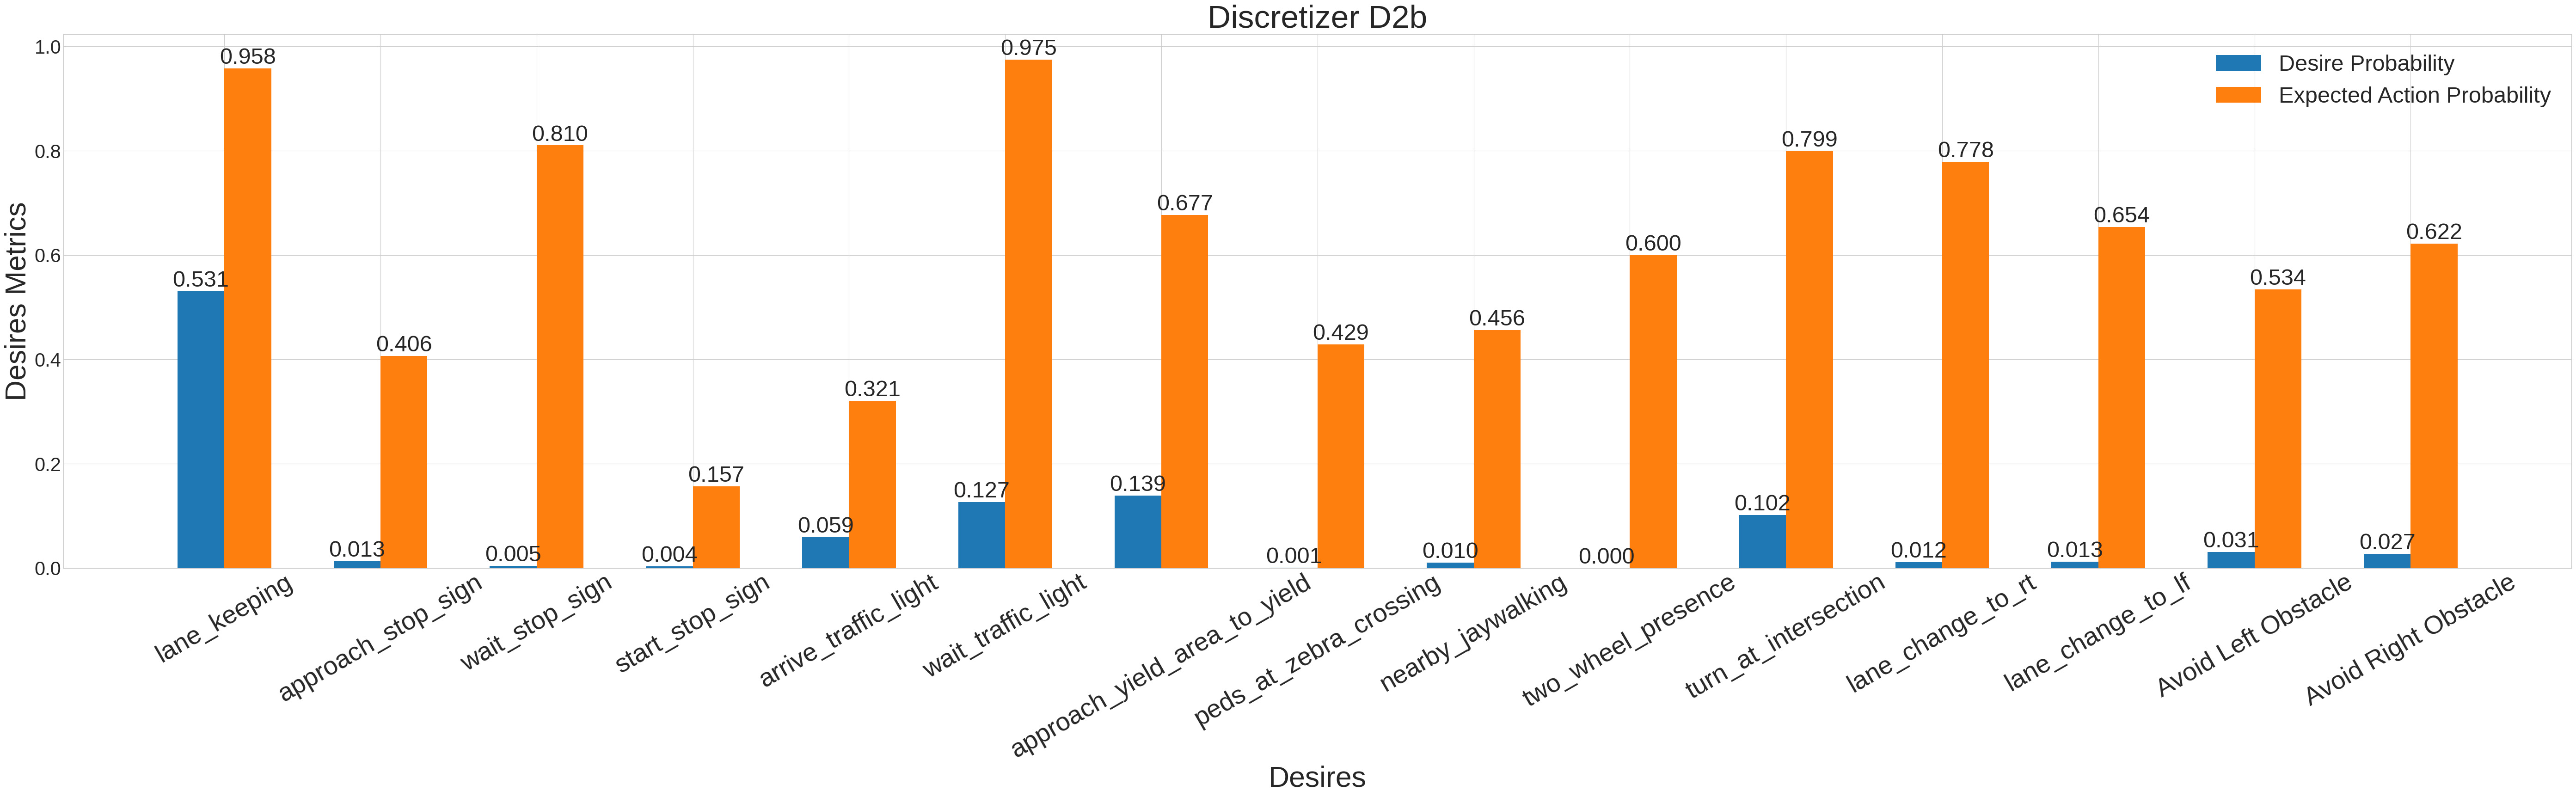

In [ ]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')


#### Intentions

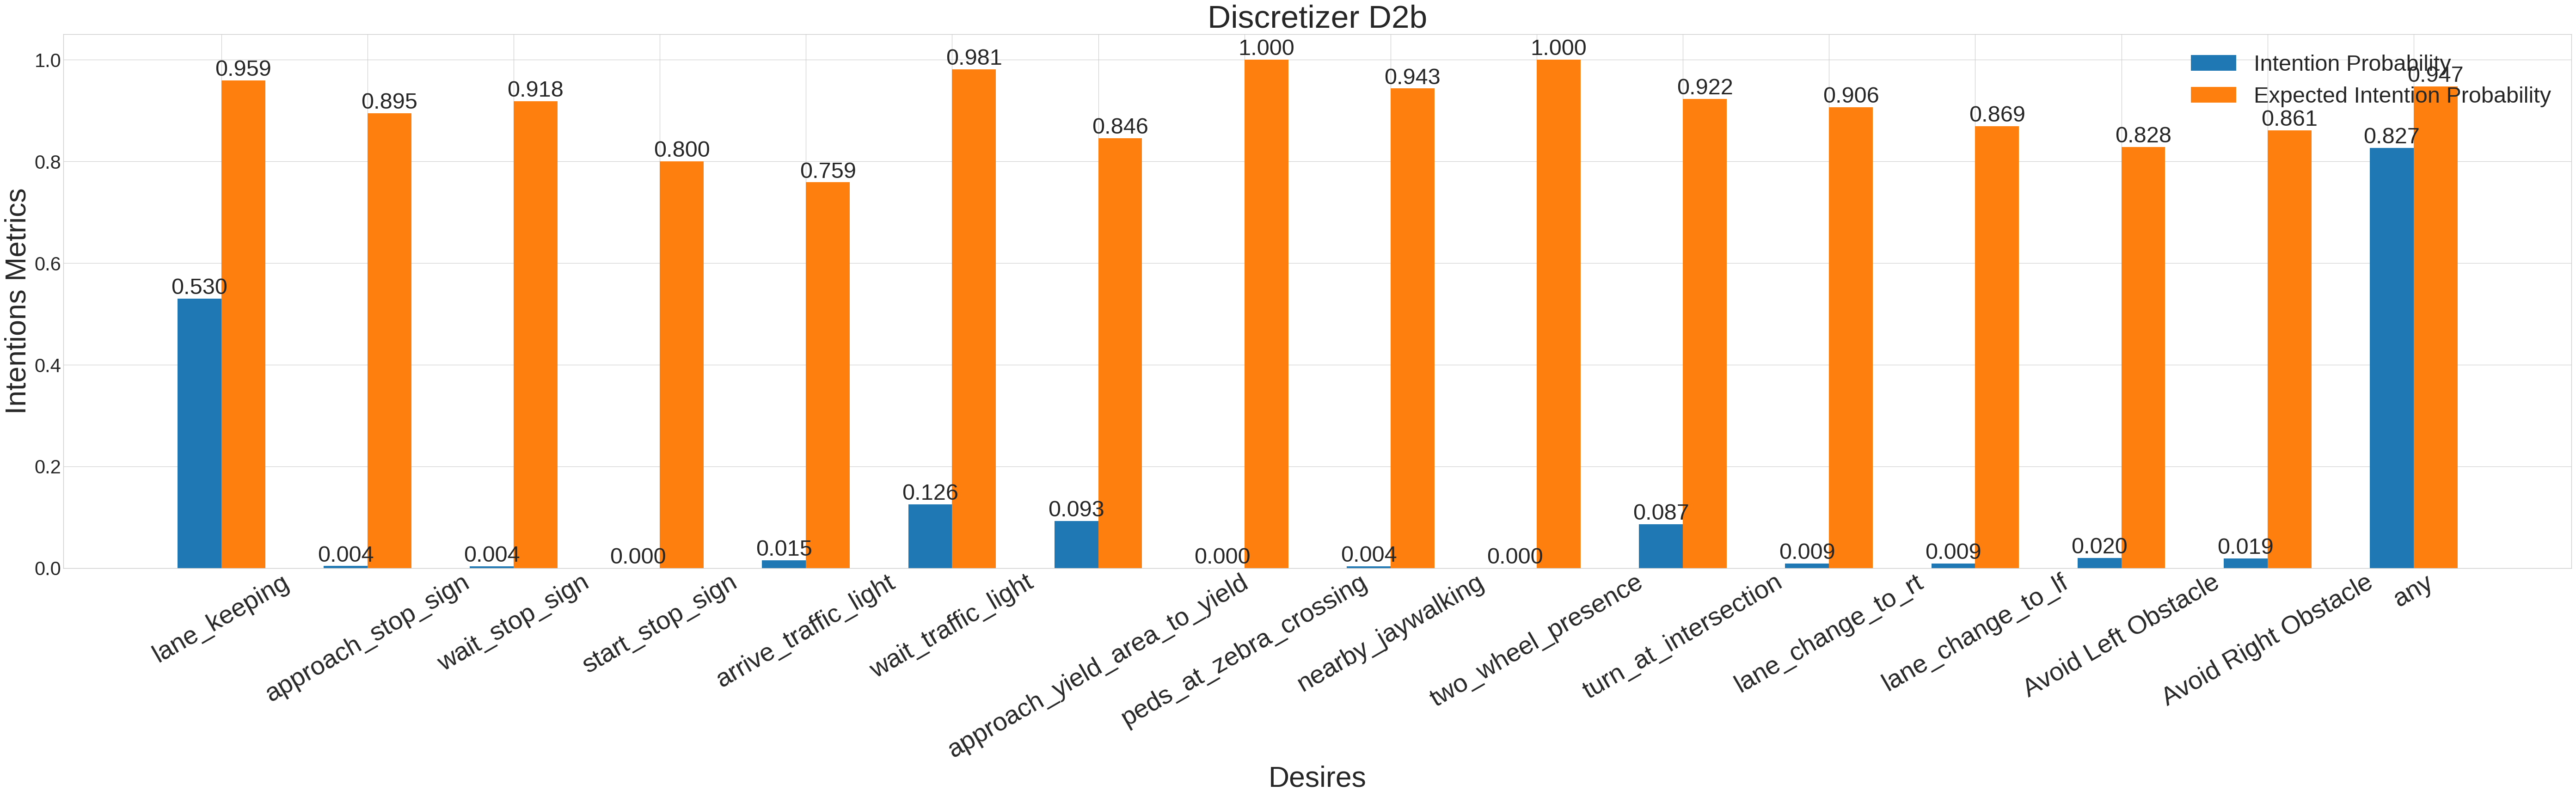

In [ ]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

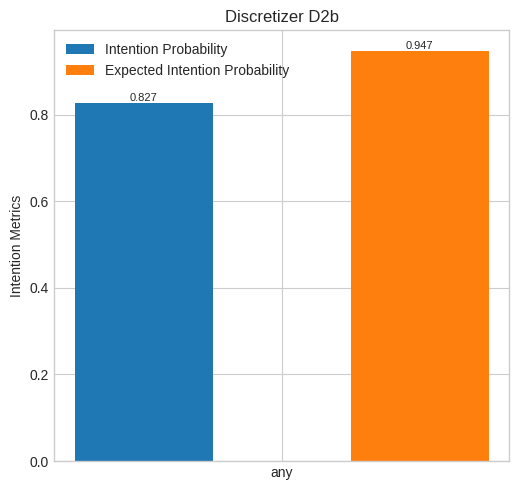

In [ ]:
show_all_metrics_per_desire(intentions_data, "any", type='Intention')


## ROC Curve


Choose the discretiser with higher AIC, that is, the discretiser where the interpretability vs reliability trade-off is better

- If there is no commitment threshold in which the two metrics are decently high, it becomes apparent that the desires do not capture the agent’s behaviour. This can be either because the agent did not train correctly (making the hypothesised desires something it cannot reach) or because the agent is targeting a different set of desires. Our case is the latter. 

- The probability of manifesting intentions is low. the behaviour is not interpretable with these desires, and new ones should be considered.


After seeing seeing this, we added new desires related to OBSTACLE AVOIDANCE, which improved the AUC  for discretisers D0b and D0c.

In [ ]:
discretizers_info = {}
for discretizer_id in ['0a','0b','1a','1b']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
            ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    discretizers_info[discretizer_id] = (pg, desires)


In [ ]:
#roc_curve(discretizers_info)

## TEST ON 1 SCENE

Scene 61, token cc8c0bf57f984915a77078b10eb33198

In [ ]:
import pandas as pd
intentions_data = {}
desires_data = {}
discretizer_id = '2b'
scene_token = '0053e9c440a94c1b84bd9c4223efc4b0'
city = "boston-seaport"
env = SelfDrivingEnvironment(city)
disc = AVDiscretizerD2(env, vel_discretization='multiple',id=discretizer_id)
pg = PG.PolicyGraph(env, disc)
dtype_dict = {
        'modality': 'category',  # for limited set of modalities, 'category' is efficient
        'scene_token': 'str',  
        'steering_angle': 'float64', 
        'rain': 'int',
        'night':'int',
        'location': 'str',
        'timestamp': 'str',  # To enable datetime operations
        'rotation': 'object',  # Quaternion (lists)
        'x': 'float64',
        'y': 'float64',
        'z': 'float64',
        'yaw': 'float64',  
        'velocity': 'float64',
        'acceleration': 'float64',
        'yaw_rate': 'float64'
    }
df = pd.read_csv('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes/full_v1.0-trainval_lidar_1_10.csv', dtype=dtype_dict, parse_dates=['timestamp'])
df = df[df['location'] == city]
df = df[df['scene_token']==scene_token]
pg = pg.fit(df, update=False, verbose=True)
    

ii = IntentionIntrospector(desires, pg)

desires_data[discretizer_id] = ii.find_desires() 
print(desires_data[discretizer_id])
intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
print(intentions_data[discretizer_id])
print()

Fitting PG from scenes...:   0%|          | 0/1 [00:00<?, ?it/s]

scene token: 0053e9c440a94c1b84bd9c4223efc4b0
[IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
[IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
[IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
[IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), Is

Fitting PG from scenes...: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]

frame 0 --> [IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(RIGHT), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
action: Action.IDLE
frame 1 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(RIGHT), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
action: Action.IDLE
frame 2 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(RIGHT), Velocity(STOPPED), Rotation(FORWARD), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(NO), FrontObjects(NO)]
action: Action.IDLE
frame 3 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(RIGHT), V

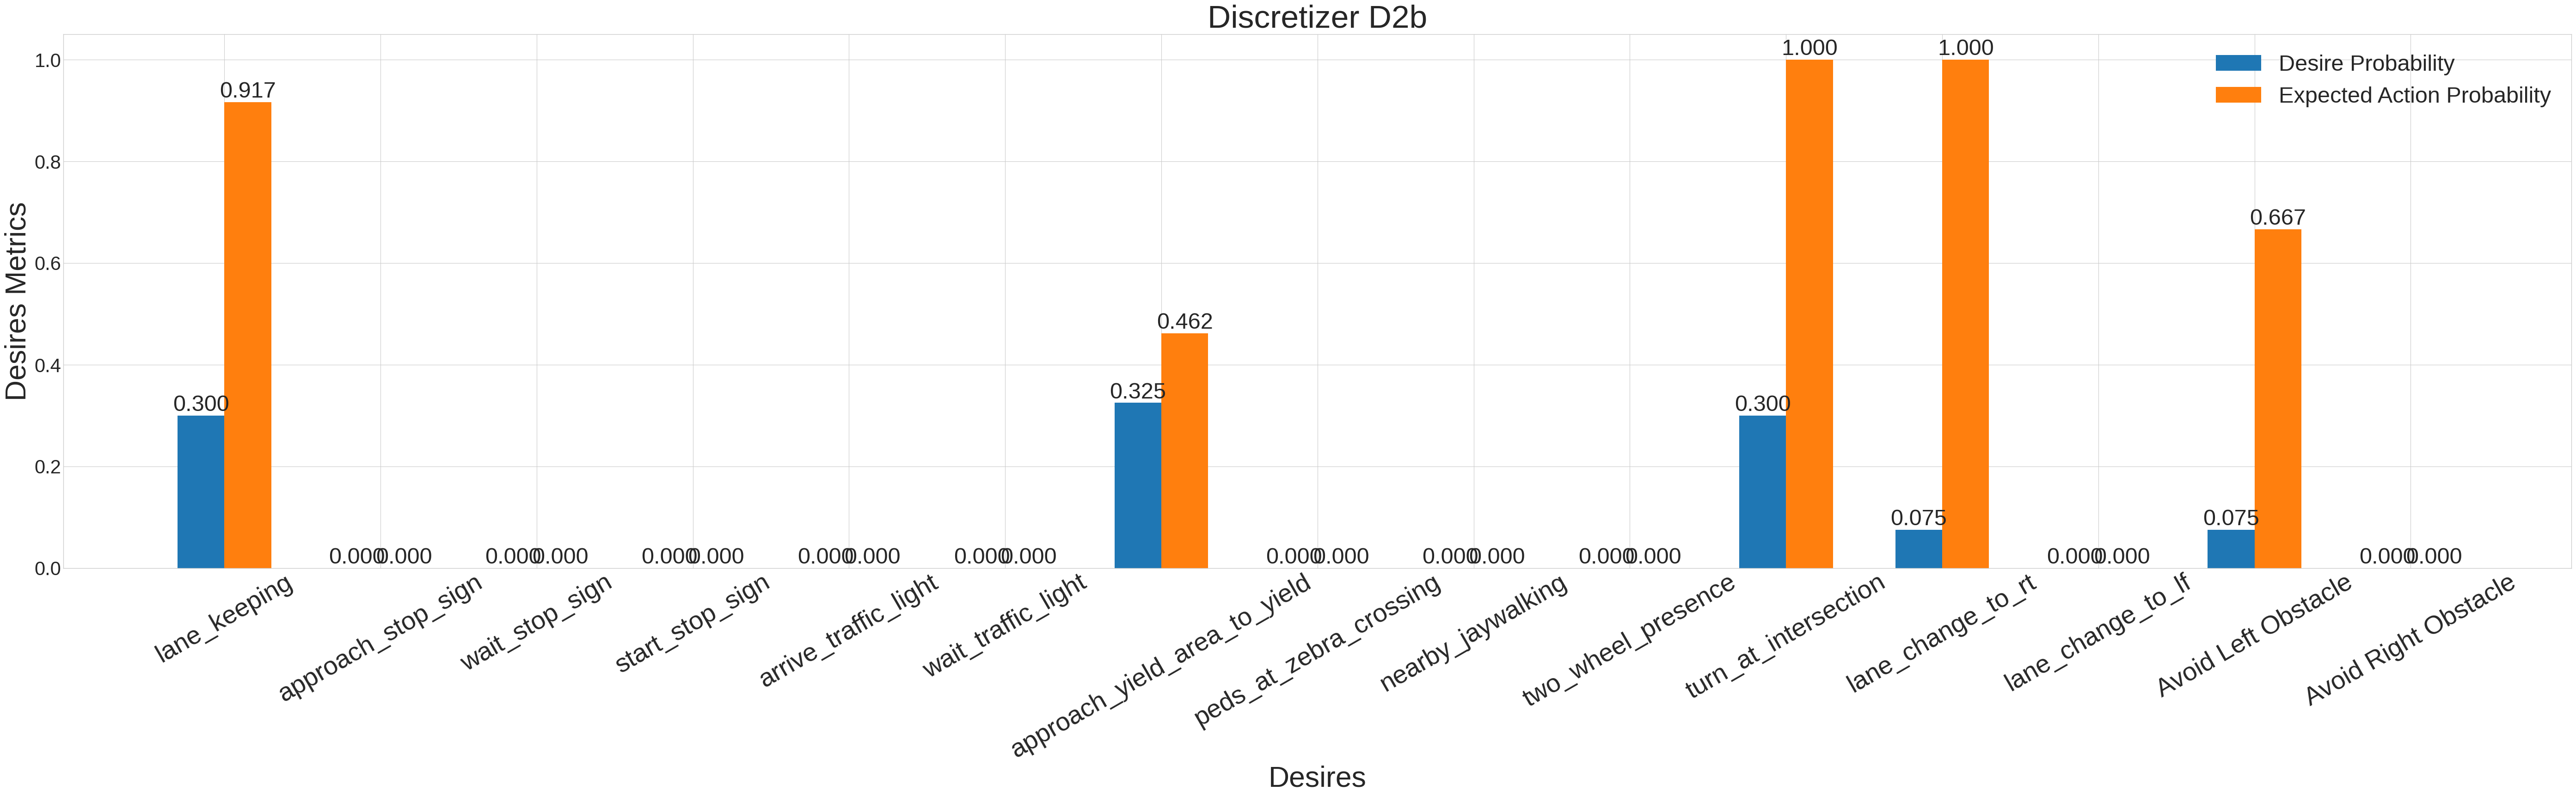

In [ ]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')


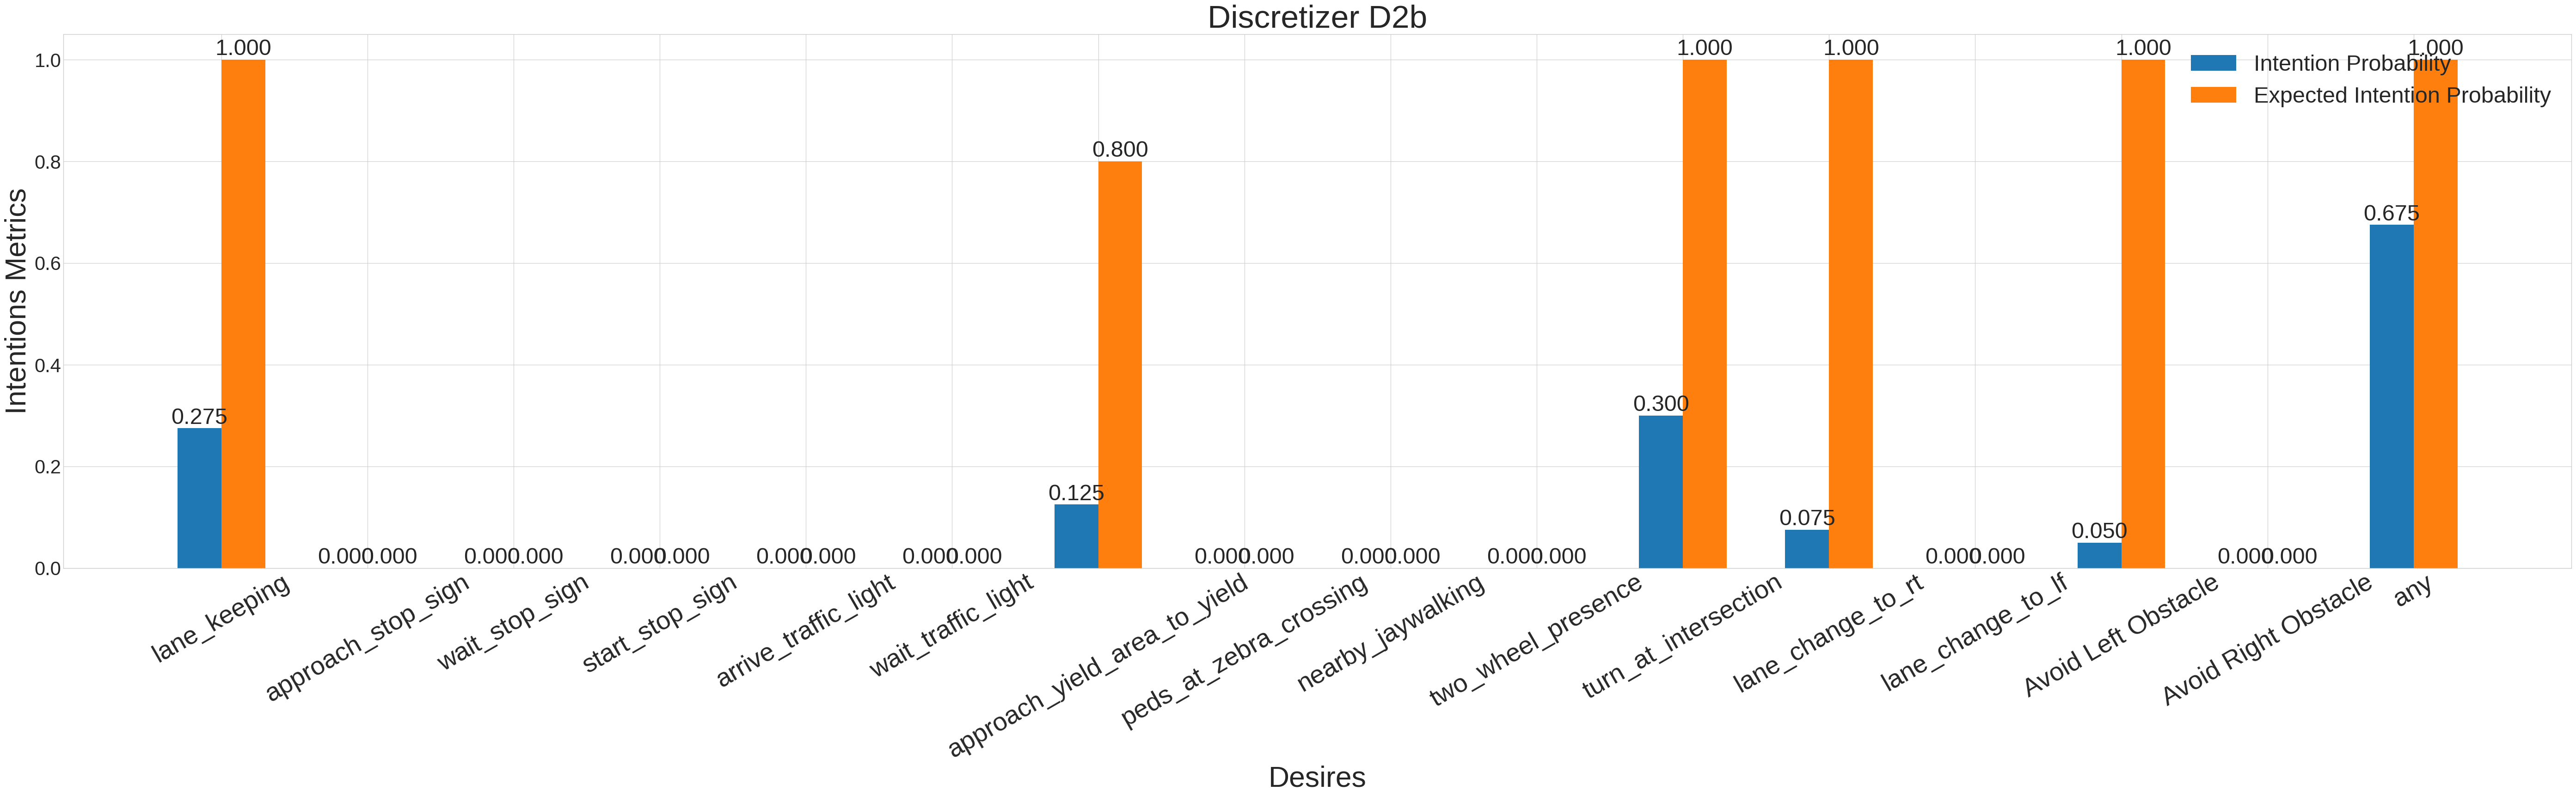

In [ ]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

#### QUESTIONS

In [ ]:
ii.question6(lane_keeping,list(pg.nodes())[0])


How do you plan to fulfill lane_keeping from state (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(START), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(RIGHT), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontObjects(NO))?
[]


In [ ]:
list(pg.nodes())[10]

(IdleTime(5+),
 PedestrianNearby(NO),
 IsTwoWheelNearby(NO),
 BlockProgress(END),
 LanePosition(ALIGNED),
 NextIntersection(RIGHT),
 Velocity(STOPPED),
 Rotation(FORWARD),
 StopAreaNearby(TURN_STOP),
 IsZebraNearby(YES),
 IsTrafficLightNearby(NO),
 FrontObjects(NO))